In [5]:
import numpy as np
import pandas as pd

## Importing text data

In [6]:
from google.colab import files
uploaded = files.upload()

Saving MLUnige2021_train.csv to MLUnige2021_train.csv


In [7]:
import io

tweet = pd.read_csv(io.BytesIO(uploaded['MLUnige2021_train.csv']))
tweet.head(10)

,Id,emotion,tweet_id,date,lyx_query,user,text
0,0,1,2063391019,Sun Jun 07 02:28:13 PDT 2009,NO_QUERY,BerryGurus,@BreeMe more time to play with you BlackBerry ...
1,1,0,2000525676,Mon Jun 01 22:18:53 PDT 2009,NO_QUERY,peterlanoie,Failed attempt at booting to a flash drive. Th...
2,2,0,2218180611,Wed Jun 17 22:01:38 PDT 2009,NO_QUERY,will_tooker,@msproductions Well ain't that the truth. Wher...
3,3,1,2190269101,Tue Jun 16 02:14:47 PDT 2009,NO_QUERY,sammutimer,@Meaghery cheers Craig - that was really sweet...
4,4,0,2069249490,Sun Jun 07 15:31:58 PDT 2009,NO_QUERY,ohaijustin,I was reading the tweets that got send to me w...
5,5,1,1984986437,Sun May 31 16:12:03 PDT 2009,NO_QUERY,TeamEllenCanada,@simpleliving1 it would be awesome if you cold...
6,6,1,1965561962,Fri May 29 16:08:19 PDT 2009,NO_QUERY,jessameow,@ShandeeMcMahill - Shandee! I didn't know you ...
7,7,1,1971453717,Sat May 30 07:08:58 PDT 2009,NO_QUERY,Josette_78,Good morning twitter fam! Today is my born day...
8,8,1,1825826258,Sun May 17 06:57:22 PDT 2009,NO_QUERY,pga1ht,Listening to my out-of-school children complai...
9,9,1,1993750450,Mon Jun 01 10:52:22 PDT 2009,NO_QUERY,mixtacy,~My LIVE Memorial Day Mix~ ... just added at ...


## Data Pre-Processing

In [10]:
#Drop unnecessary columns
tweet.df = tweet.drop(['tweet_id', 'date', 'lyx_query','user'], axis=1)
tweet.df.head(10)

,Id,emotion,text
0,0,1,@BreeMe more time to play with you BlackBerry ...
1,1,0,Failed attempt at booting to a flash drive. Th...
2,2,0,@msproductions Well ain't that the truth. Wher...
3,3,1,@Meaghery cheers Craig - that was really sweet...
4,4,0,I was reading the tweets that got send to me w...
5,5,1,@simpleliving1 it would be awesome if you cold...
6,6,1,@ShandeeMcMahill - Shandee! I didn't know you ...
7,7,1,Good morning twitter fam! Today is my born day...
8,8,1,Listening to my out-of-school children complai...
9,9,1,~My LIVE Memorial Day Mix~ ... just added at ...


In [11]:
tweet.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280000 entries, 0 to 1279999
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   Id       1280000 non-null  int64 
 1   emotion  1280000 non-null  int64 
 2   text     1280000 non-null  object
dtypes: int64(2), object(1)
memory usage: 29.3+ MB


#### Convert emotion column as object

In [12]:
tweet.df['emotion'] = tweet.df.emotion.astype(object)
tweet.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280000 entries, 0 to 1279999
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   Id       1280000 non-null  int64 
 1   emotion  1280000 non-null  object
 2   text     1280000 non-null  object
dtypes: int64(1), object(2)
memory usage: 29.3+ MB


### Emotions distribution

In [13]:
tweet.df['emotion'].value_counts()

1    640118
0    639882
Name: emotion, dtype: int64

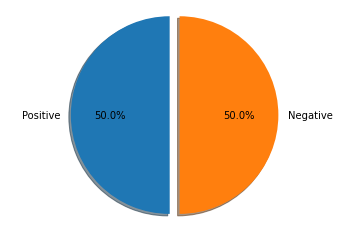

In [14]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Positive', 'Negative'
sizes = [640118, 639882]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Proportion of Positive and Negative tweets are almost equal in our training data set

## Sentiment Classification Using BERT

In [15]:

!pip install tensorflow-gpu >> /dev/null

In [16]:
!pip install --upgrade grpcio >> /dev/null

ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.37.0 which is incompatible.
ERROR: tensorflow-gpu 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.37.0 which is incompatible.


In [17]:
!pip install tqdm  >> /dev/null

In [18]:
!pip install bert-for-tf2 >> /dev/null

In [19]:

!pip install sentencepiece >> /dev/null

In [21]:
import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
  text = hashtags.sub(' hashtag', text)
  text = mentions.sub(' entity', text)
  return text.strip().lower()
  
def match_expr(pattern, string):
  return not pattern.search(string) == None

def get_data_wo_urls(dataset):
    link_with_urls = dataset.text.apply(lambda x: match_expr(urls, x))
    return dataset[[not e for e in link_with_urls]]

In [23]:
tweet.df.text = tweet.df.text.apply(process_text)

In [24]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [25]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(tweet.df, test_size=0.2,
                                         random_state=42)

In [28]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2021-04-29 19:50:39--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   111MB/s    in 3.5s    

2021-04-29 19:50:43 (111 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [29]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [30]:
os.makedirs("model", exist_ok=True)

In [31]:
!mv uncased_L-12_H-768_A-12/ model

In [32]:

bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [33]:
class emotionDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "emotion"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    train, test = map(lambda df: df.reindex(df[emotionDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[emotionDetectionData.DATA_COLUMN], row[emotionDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [34]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [35]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

## Training

In [36]:
classes = train.emotion.unique().tolist()

data = emotionDetectionData(train, test, tokenizer, classes, max_seq_len=128)

1024000it [07:37, 2237.27it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
256000it [01:52, 2268.39it/s]


max seq_len 162


In [38]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 128, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f55600c0d10> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [39]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1538  

In [40]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [41]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5,
  callbacks=[tensorboard_callback]
)

Epoch 1/5
   30/57600 [..............................] - ETA: 357:38:04 - loss: 0.8676 - acc: 0.5210

KeyboardInterrupt: ignored

## Evaluation

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir log

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [ ]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)